# Stage 2 — Budget & Baseline Comparison

In this stage we evaluate how **IVF-CE (Config B)** performs across different
total cluster budgets `B`, and compare it against two reference methods:

- **IVF baseline** with `nprobe = B`
- **Brute force** (full exact search)

The goal is to understand how accuracy (Recall@10/50/100) and latency scale as we
redistribute a fixed budget `B` across Stage-1 (`n1`) and Stage-2 (`n2`) exploration,
and to see how close each method approaches brute-force quality.

---

##  How the Stage-2 results are generated

1. **Load dataset & query subset**  
   We reuse the same SIFT1M base vectors and fixed set of 1,000 queries from Stage 1.

2. **Load IVF-CE index (Config B)**  
   The index was already built in Stage 1, using:
   - `m_max = 16`, `k1 = 60`, `p_index = 10`
   - `n_clusters = 1024`

3. **Build IVF baseline index**  
   A standard IVF index is constructed with the same coarse clustering as IVF-CE,
   so the comparison is fair.

4. **Build brute-force reference**  
   A simple linear search index over the full dataset.

5. **Evaluate methods across budgets**  
   For each `B ∈ {2, 3, 4, 5, 6, 8}`:
   - IVF-CE is run for **all** valid `(n1, n2)` pairs where `n1 + n2 = B` and `n1, n2 > 0`.
   - For each budget, we mark the **best** `(n1, n2)` split by highest Recall@10  
     (tie-broken by lowest latency).
   - IVF is run once per `B` with `nprobe = B`.
   - Brute force is run once on the same queries.

6. **Logging**  
   All evaluations are written to:
   ```bash
   results/logs/stage2_results.jsonl
   ```
---

##  What this notebook analyzes

- **Recall–latency trade-off** across IVF-CE, IVF, and brute-force.  
- **Recall vs budget curves** showing how methods scale with `B`.  
- **Indexing cost comparison** (one-time build time).  
- **Effect of redistributing B between n1 and n2**, i.e., the value of Stage-2 exploration.

These results allow us to understand where IVF-CE improves over standard IVF, how
large the gains are at different budgets, and how close each method comes to the
exact (brute-force) quality benchmark.


## Setup and configuration

Import dependencies, point to the repository root, and define the shared settings for Stage 2:
dataset (`sift1m`), query/sample settings, budgets `B`, fixed `k2`, Config B parameters, index paths, and output log path.
We also control whether to (re)run evaluations via `RUN_EVALUATIONS`.

In [1]:
from __future__ import annotations

from pathlib import Path
import sys
import json
from datetime import datetime
from time import perf_counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

repo_root = Path("/home/student/ivf-ce-ann")

if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from data.dataset_loader import load_dataset
from experiments.utils import select_queries
from evaluation.evaluator import Evaluator
from src.baselines.bruteforce import BruteForceSearch
from src.index.ivf_ce_index import IVFCEIndex
from src.index.ivf_index import IVFIndex
from src.search.ivf_ce_searcher import IVFCEExplorer
from src.search.ivf_searcher import IVFSearcher

sns.set_theme(style="whitegrid")

DATASET_NAME = "sift1m"
DATASET_ROOT = repo_root / "data"
QUERY_COUNT = 1000
QUERY_SEED = 0
K_VALUES = (10, 50, 100)
BUDGETS = (2, 3, 4, 5, 6, 8)
K2_FIXED = 100

CONFIG_B_PARAMS = {
    "n_clusters": 1024,
    "n_init": 1,
    "max_iter": 100,
    "seed": 123,
    "m_max": 16,
    "k1": 60,
    "p_index": 10,
}

IVFCE_INDEX_PATH = repo_root / "results/indexes/ivfce_sift1m_b_20251109.idx"
IVF_BASELINE_CACHE = repo_root / "results/indexes/ivf_stage2_baseline.idx"
STAGE2_RESULTS_PATH = repo_root / "results/logs/stage2_results.jsonl"

RUN_EVALUATIONS = False  # flip to True to regenerate Stage 2 numbers



## Load SIFT1M data + Stage-1 query slice

In [2]:
base_vectors, query_vectors, ground_truth = load_dataset(DATASET_NAME, DATASET_ROOT)
queries_subset, gt_subset = select_queries(
    query_vectors,
    ground_truth,
    QUERY_COUNT,
    seed=QUERY_SEED,
)

evaluator = Evaluator(gt_subset)
print(f"Base vectors: {base_vectors.shape}\nQueries used: {queries_subset.shape}")


Base vectors: (1000000, 128)
Queries used: (1000, 128)


## Load IVF-CE Config B index, build IVF baseline + brute force

In [3]:
if not IVFCE_INDEX_PATH.exists():
    raise FileNotFoundError(
        f"Missing IVF-CE index for Config B: {IVFCE_INDEX_PATH}. "
        "Re-run Stage 1 build to generate it."
    )

ivfce_index = IVFCEIndex.load(IVFCE_INDEX_PATH)
ivfce_build_time = (
    ivfce_index.build_stats.total if ivfce_index.build_stats else 0.0
)
dimension = ivfce_index.dimension
n_clusters = ivfce_index.n_clusters
print(
    f"Loaded IVF-CE Config B index from {IVFCE_INDEX_PATH} | "
    f"dim={dimension}, clusters={n_clusters}, build_time={ivfce_build_time/3600:.2f}h"
)

if IVF_BASELINE_CACHE.exists():
    ivf_index = IVFIndex.load(IVF_BASELINE_CACHE)
    ivf_build_time = ivf_index.build_stats.total if ivf_index.build_stats else 0.0
    print(f"Loaded cached IVF baseline from {IVF_BASELINE_CACHE}.")
else:
    IVF_BASELINE_CACHE.parent.mkdir(parents=True, exist_ok=True)
    ivf_index = IVFIndex(
        dimension=dimension,
        n_clusters=CONFIG_B_PARAMS["n_clusters"],
        n_init=CONFIG_B_PARAMS["n_init"],
        max_iter=CONFIG_B_PARAMS["max_iter"],
        seed=CONFIG_B_PARAMS["seed"],
    )
    build_start = perf_counter()
    ivf_index.build(base_vectors)
    ivf_build_time = (
        ivf_index.build_stats.total if ivf_index.build_stats else perf_counter() - build_start
    )
    ivf_index.save(IVF_BASELINE_CACHE)
    print(f"Built IVF baseline and cached to {IVF_BASELINE_CACHE}.")

bruteforce = BruteForceSearch()
bf_start = perf_counter()
bruteforce.build(base_vectors)
bruteforce_build_time = perf_counter() - bf_start
print(f"Brute-force reference built in {bruteforce_build_time/60:.2f} min.")

build_time_registry = {
    "ivf_ce": ivfce_build_time,
    "ivf": ivf_build_time,
    "bruteforce": bruteforce_build_time,
}


Loaded IVF-CE Config B index from /home/student/ivf-ce-ann/results/indexes/ivfce_sift1m_b_20251109.idx | dim=128, clusters=1024, build_time=2.94h
Loaded cached IVF baseline from /home/student/ivf-ce-ann/results/indexes/ivf_stage2_baseline.idx.
Brute-force reference built in 0.00 min.


## Run Stage 2 sweeps + log results
Evaluate IVF-CE (all `(n1, n2)` splits), IVF (with `nprobe = B`), and brute force on the fixed query set.  
Results are written to `stage2_results.jsonl` when `RUN_EVALUATIONS=True`; otherwise, the existing log is reused.

In [4]:
def _result_to_row(method_meta: dict, eval_result) -> dict:
    row = method_meta.copy()
    row.update(
        {
            "recall_at_10": float(eval_result.recalls.get(10, float("nan"))),
            "recall_at_50": float(eval_result.recalls.get(50, float("nan"))),
            "recall_at_100": float(eval_result.recalls.get(100, float("nan"))),
            "avg_query_time_ms": float(eval_result.query_time_ms),
            "latency_p50_ms": float(eval_result.latency_p50_ms),
            "latency_p95_ms": float(eval_result.latency_p95_ms),
            "qps": float(eval_result.qps),
            "timestamp": datetime.utcnow().isoformat(),
        }
    )
    return row

if RUN_EVALUATIONS:
    stage2_rows: list[dict] = []
    base_metadata = {
        "dataset_name": DATASET_NAME,
        "dataset_size": int(base_vectors.shape[0]),
        "query_count": int(queries_subset.shape[0]),
        "query_seed": QUERY_SEED,
        "k_values": list(K_VALUES),
    }

    # IVF-CE sweeps across all (n1, n2) for each budget.
    ivf_ce_rows: list[dict] = []
    for B in BUDGETS:
        for n2 in range(1, B):
            n1 = B - n2
            explorer = IVFCEExplorer(
                ivfce_index,
                n1=n1,
                n2=n2,
                k2=K2_FIXED,
            )
            result = evaluator.evaluate(explorer, queries_subset, K_VALUES)
            payload = {
                **base_metadata,
                "method": "ivf_ce",
                "config_name": "B",
                "B": int(B),
                "n1": int(n1),
                "n2": int(n2),
                "k2": int(K2_FIXED),
                "nprobe": None,
                "is_best_split": False,
                "is_full_dataset": False,
                "index_build_time_total_s": float(build_time_registry["ivf_ce"]),
            }
            ivf_ce_rows.append(_result_to_row(payload, result))

    # Flag the best split per budget (max R@10, tie -> lower latency).
    for B in BUDGETS:
        candidates = [row for row in ivf_ce_rows if row["B"] == B]
        if not candidates:
            continue
        candidates.sort(key=lambda row: (-row["recall_at_10"], row["avg_query_time_ms"]))
        candidates[0]["is_best_split"] = True

    stage2_rows.extend(ivf_ce_rows)

    # IVF baseline per budget (nprobe == B).
    for B in BUDGETS:
        searcher = IVFSearcher(ivf_index, nprobe=int(B))
        result = evaluator.evaluate(searcher, queries_subset, K_VALUES)
        payload = {
            **base_metadata,
            "method": "ivf",
            "config_name": None,
            "B": int(B),
            "n1": None,
            "n2": None,
            "k2": None,
            "nprobe": int(B),
            "is_best_split": False,
            "is_full_dataset": False,
            "index_build_time_total_s": float(build_time_registry["ivf"]),
        }
        stage2_rows.append(_result_to_row(payload, result))

    # Brute-force reference (full dataset).
    bf_result = evaluator.evaluate(bruteforce, queries_subset, K_VALUES)
    bf_row = {
        **base_metadata,
        "method": "bruteforce",
        "config_name": None,
        "B": None,
        "n1": None,
        "n2": None,
        "k2": None,
        "nprobe": None,
        "is_best_split": False,
        "is_full_dataset": True,
        "index_build_time_total_s": float(build_time_registry["bruteforce"]),
    }
    stage2_rows.append(_result_to_row(bf_row, bf_result))

    STAGE2_RESULTS_PATH.parent.mkdir(parents=True, exist_ok=True)
    with STAGE2_RESULTS_PATH.open("w", encoding="utf-8") as handle:
        for row in stage2_rows:
            handle.write(json.dumps(row) + "\n")
    print(f"Wrote {len(stage2_rows)} rows to {STAGE2_RESULTS_PATH}")
else:
    if STAGE2_RESULTS_PATH.exists():
        print(
            "Skipping evaluation (RUN_EVALUATIONS=False); "
            f"reusing {STAGE2_RESULTS_PATH} for analysis."
        )
    else:
        print("Stage 2 log missing. Set RUN_EVALUATIONS=True and rerun this cell.")


Skipping evaluation (RUN_EVALUATIONS=False); reusing /home/student/ivf-ce-ann/results/logs/stage2_results.jsonl for analysis.


## Load Stage 2 results for plotting

In [5]:
if not STAGE2_RESULTS_PATH.exists():
    raise FileNotFoundError(
        f"Missing Stage 2 log: {STAGE2_RESULTS_PATH}. "
        "Run the previous cell to generate it."
    )

stage2_df = pd.read_json(STAGE2_RESULTS_PATH, lines=True)
stage2_df = stage2_df.sort_values(
    by=["method", "B", "n1", "n2", "nprobe"],
    na_position="last"
).reset_index(drop=True)
print(f"Loaded {len(stage2_df)} Stage 2 runs.")
stage2_df.head()


Loaded 29 Stage 2 runs.


,dataset_name,dataset_size,query_count,query_seed,k_values,method,config_name,B,n1,n2,...,is_full_dataset,index_build_time_total_s,recall_at_10,recall_at_50,recall_at_100,avg_query_time_ms,latency_p50_ms,latency_p95_ms,qps,timestamp
0,sift1m,1000000,1000,0,"[10, 50, 100]",bruteforce,None,NaN,NaN,NaN,...,True,0.200289,0.9988,0.99976,0.99986,303.935409,301.748779,316.122620,3.290173,2025-11-10 18:51:12.509020
1,sift1m,1000000,1000,0,"[10, 50, 100]",ivf,None,2.0,NaN,NaN,...,False,113.924314,0.5414,0.47506,0.44087,2.585047,2.446870,3.653976,386.840200,2025-11-10 18:45:39.904996
2,sift1m,1000000,1000,0,"[10, 50, 100]",ivf,None,3.0,NaN,NaN,...,False,113.924314,0.6395,0.57196,0.53725,3.567372,3.402089,4.922804,280.318429,2025-11-10 18:45:43.506952
3,sift1m,1000000,1000,0,"[10, 50, 100]",ivf,None,4.0,NaN,NaN,...,False,113.924314,0.7053,0.64140,0.60667,4.507180,4.287710,6.126835,221.868222,2025-11-10 18:45:48.052128
4,sift1m,1000000,1000,0,"[10, 50, 100]",ivf,None,5.0,NaN,NaN,...,False,113.924314,0.7533,0.69470,0.66149,5.479362,5.230829,7.693034,182.502986,2025-11-10 18:45:53.571936


## (a) Recall–latency trade-off across methods
We compare IVF-CE (all splits and best splits), IVF with `nprobe = B`, and brute force on a single recall–latency plot.  
This highlights how each method balances accuracy and runtime under equal cluster budgets.

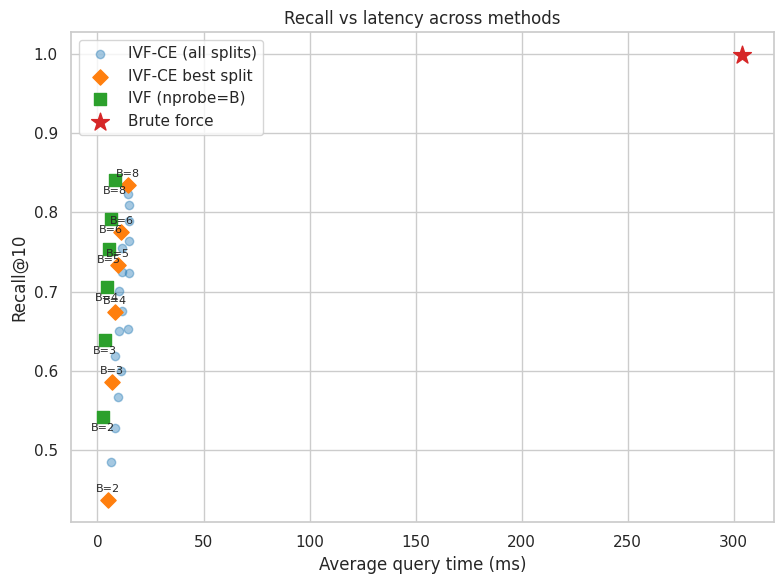

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))
ce_df = stage2_df[stage2_df["method"] == "ivf_ce"]
ivf_df = stage2_df[stage2_df["method"] == "ivf"]
bf_df = stage2_df[stage2_df["method"] == "bruteforce"]

if not ce_df.empty:
    ax.scatter(
        ce_df["avg_query_time_ms"],
        ce_df["recall_at_10"],
        alpha=0.4,
        label="IVF-CE (all splits)",
        color="#1f77b4",
    )
    best_points = ce_df[ce_df["is_best_split"]]
    if not best_points.empty:
        ax.scatter(
            best_points["avg_query_time_ms"],
            best_points["recall_at_10"],
            color="#ff7f0e",
            marker="D",
            s=60,
            label="IVF-CE best split",
        )
        for _, row in best_points.iterrows():
            ax.annotate(
                f"B={int(row['B'])}",
                (row["avg_query_time_ms"], row["recall_at_10"]),
                textcoords="offset points",
                xytext=(0, 6),
                ha="center",
                fontsize=8,
            )

if not ivf_df.empty:
    ax.scatter(
        ivf_df["avg_query_time_ms"],
        ivf_df["recall_at_10"],
        color="#2ca02c",
        marker="s",
        s=70,
        label="IVF (nprobe=B)",
    )
    for _, row in ivf_df.iterrows():
        ax.annotate(
            f"B={int(row['B'])}",
            (row["avg_query_time_ms"], row["recall_at_10"]),
            textcoords="offset points",
            xytext=(0, -10),
            ha="center",
            fontsize=8,
        )

if not bf_df.empty:
    ax.scatter(
        bf_df["avg_query_time_ms"],
        bf_df["recall_at_10"],
        color="#d62728",
        marker="*",
        s=180,
        label="Brute force",
    )

ax.set_xlabel("Average query time (ms)")
ax.set_ylabel("Recall@10")
ax.set_title("Recall vs latency across methods")
ax.legend()
plt.tight_layout()
plt.show()


## Plot b — Recall vs budget (best IVF-CE split per B)
For each recall metric (`@10`, `@50`, `@100`), we plot how performance scales with the total budget `B`.  
Here, **“best split”** refers to the best **(n1, n2)** pair for that budget, selected by highest Recall@10 (tie-broken by lowest latency).

- **IVF-CE:** best (n1, n2) split per budget  
- **IVF:** baseline with `nprobe = B`  
- **Brute force:** shown as a horizontal reference line  

This illustrates how both methods approach brute-force quality as the search budget increases.

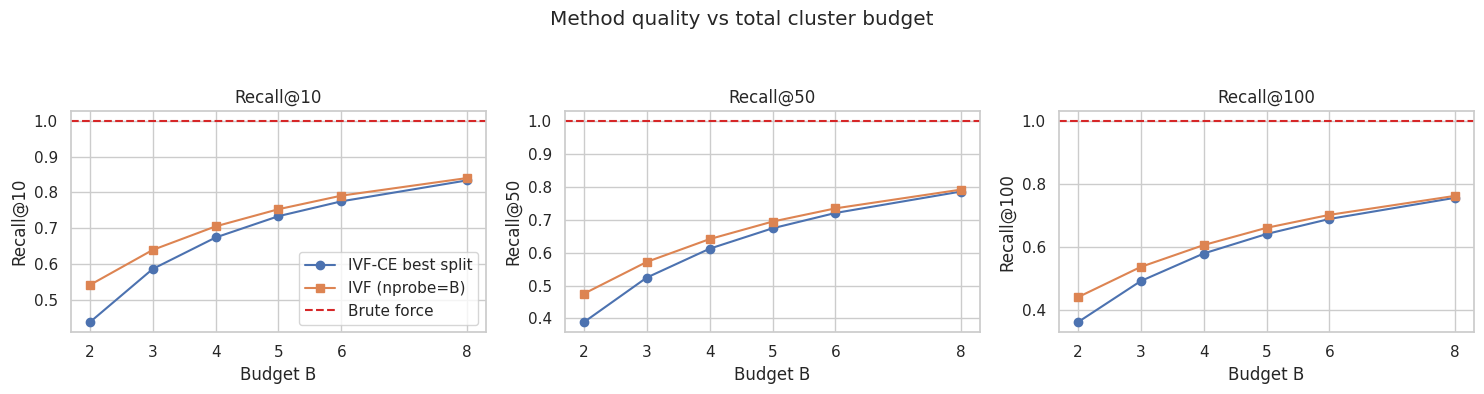

In [7]:
metrics = [
    ("recall_at_10", "Recall@10"),
    ("recall_at_50", "Recall@50"),
    ("recall_at_100", "Recall@100"),
]
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)
ce_best = stage2_df[(stage2_df["method"] == "ivf_ce") & (stage2_df["is_best_split"])]
ivf_by_B = stage2_df[stage2_df["method"] == "ivf"]
bf_row = stage2_df[stage2_df["method"] == "bruteforce"].head(1)

for ax, (metric, label) in zip(axes, metrics):
    if not ce_best.empty:
        ax.plot(
            ce_best.sort_values("B")["B"],
            ce_best.sort_values("B")[metric],
            marker="o",
            label="IVF-CE best split",
        )
    if not ivf_by_B.empty:
        ax.plot(
            ivf_by_B.sort_values("B")["B"],
            ivf_by_B.sort_values("B")[metric],
            marker="s",
            label="IVF (nprobe=B)",
        )
    if not bf_row.empty:
        ax.axhline(bf_row.iloc[0][metric], color="#d62728", linestyle="--", label="Brute force")
    ax.set_xlabel("Budget B")
    ax.set_ylabel(label)
    ax.set_xticks(sorted(set(BUDGETS)))
    ax.set_title(label)

axes[0].legend(loc="lower right")
plt.suptitle("Method quality vs total cluster budget")
plt.tight_layout(rect=(0, 0, 1, 0.92))
plt.show()


## (c) indexing cost
We compare the total build times for:
- **IVF-CE (Config B)**
- **IVF baseline**
- **Brute force**

This shows the upfront indexing cost of each method before any queries are run.

/tmp/ipykernel_15218/1060333323.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=index_times, x="method", y="build_time_s", palette="viridis", ax=ax)


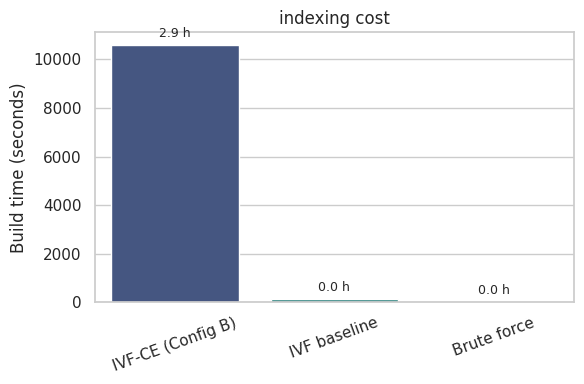

In [8]:
index_times = pd.DataFrame(
    [
        {"method": "IVF-CE (Config B)", "build_time_s": build_time_registry.get("ivf_ce", 0.0)},
        {"method": "IVF baseline", "build_time_s": build_time_registry.get("ivf", 0.0)},
        {"method": "Brute force", "build_time_s": build_time_registry.get("bruteforce", 0.0)},
    ]
)

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(data=index_times, x="method", y="build_time_s", palette="viridis", ax=ax)
ax.set_ylabel("Build time (seconds)")
ax.set_xlabel("")
ax.set_title("indexing cost")
for patch, (_, row) in zip(ax.patches, index_times.iterrows()):
    ax.annotate(
        f"{row['build_time_s']/3600:.1f} h",
        (patch.get_x() + patch.get_width() / 2, patch.get_height()),
        ha="center",
        va="bottom",
        textcoords="offset points",
        xytext=(0, 4),
        fontsize=9,
    )
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


## (d) Effect of redistributing budget between Stage-1 and Stage-2
For each total budget `B`, we vary how many clusters are assigned to Stage-2 (`n2`)
and plot the corresponding `Recall@10`.  
This shows how shifting budget from Stage-1 (`n1`) to Stage-2 (`n2`) affects accuracy.

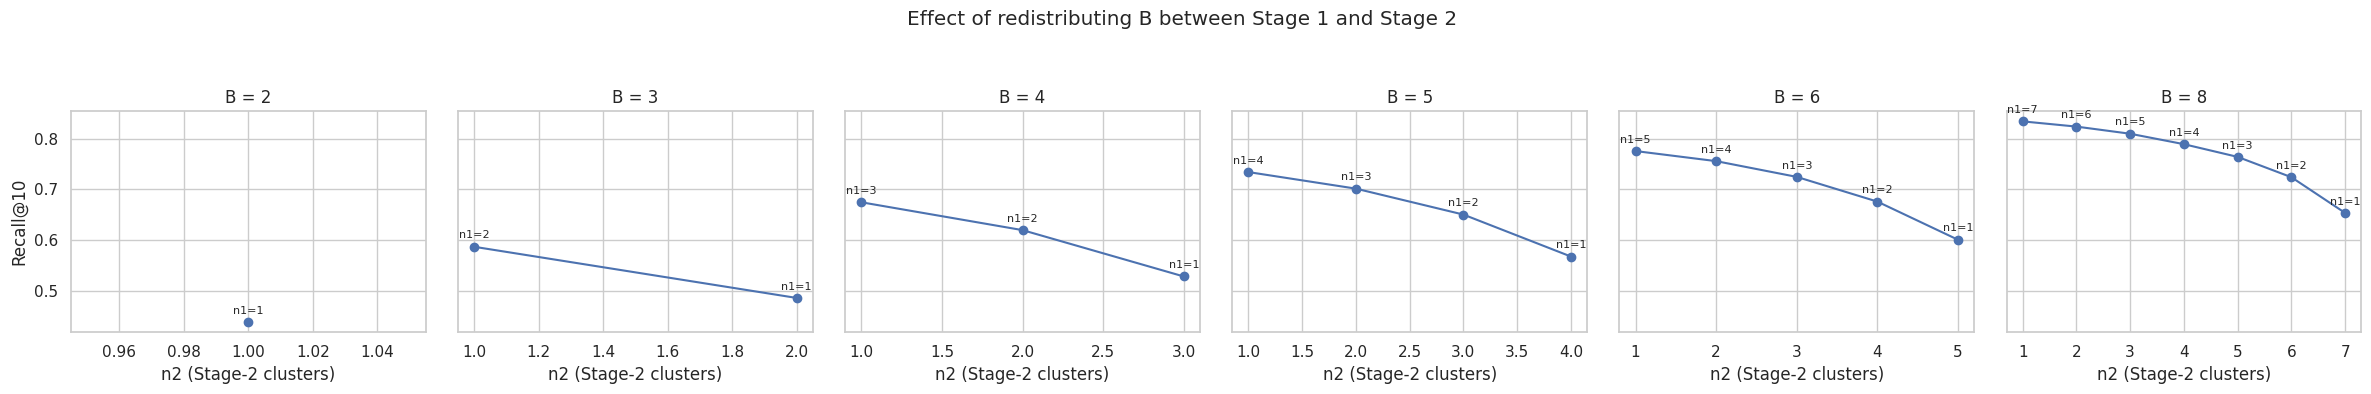

In [9]:
ce_df = stage2_df[stage2_df["method"] == "ivf_ce"]
if ce_df.empty:
    print("No IVF-CE rows available.")
else:
    unique_B = sorted(ce_df["B"].dropna().unique())
    n_cols = len(unique_B)
    fig, axes = plt.subplots(1, n_cols, figsize=(4 * n_cols, 4), sharey=True)
    if n_cols == 1:
        axes = [axes]
    for ax, B in zip(axes, unique_B):
        subset = ce_df[ce_df["B"] == B].sort_values("n2")
        ax.plot(
            subset["n2"],
            subset["recall_at_10"],
            marker="o",
            label=f"B={int(B)}",
        )
        ax.set_xlabel("n2 (Stage-2 clusters)")
        ax.set_title(f"B = {int(B)}")
        if ax is axes[0]:
            ax.set_ylabel("Recall@10")
        for _, row in subset.iterrows():
            ax.annotate(
                f"n1={int(row['n1'])}",
                (row["n2"], row["recall_at_10"]),
                textcoords="offset points",
                xytext=(0, 6),
                ha="center",
                fontsize=8,
            )
    plt.suptitle("Effect of redistributing B between Stage 1 and Stage 2")
    plt.tight_layout(rect=(0, 0, 1, 0.92))
    plt.show()
